In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

# Introduction

Welcome to a new notebook to tackle a new playground. This notebooks attempts to provide goood introductory EDA with some recommendations before modeling.

We will try making a system that can do a type of instant segmentation on wheat scanned images for a Wheat Purity Measurment system.

Thanks for reading. Don't forget to upvote if you find it useful.

* v1: inital commit

# Library Import

Some library import and some configurations of matplotlib.

In [1]:
from time import time
from datetime import timedelta
from colorama import Fore, Style
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import cv2 as cv
import os
import zipfile
from io import BytesIO
from PIL import Image
import gc
from dataAugmentationLib import placeImagesOnBackground, readImagesFromDirectories
from keras.models import load_model, clone_model
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import math
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import warnings

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

warnings.simplefilter("ignore", UserWarning)

# The Data

The dataset was generated using a Canon MX330 scanner device. Each image is labeled as x_y.jpg, where x represents each instance of cleaning the scanner and scanning with a new handful of wheat, and y represents each instance of shuffling the current scanner wheat. Additionally, there is a blank.jpg, an empty scanned image used for data augmentation.

Some key aspects are:

* There is a folder named "augmented" where we will generate our synthetic data.
* There is a folder named "objects\wheat" where extracted images of wheat or miscellaneous seeds will be stored.

In [2]:
scannedImagesNames = ["1_1.jpg", "1_2.jpg", "2_1.jpg", "3_1.jpg", "3_2.jpg"] # rest of images are kept for test
scannedImages = []
for sim in scannedImagesNames:
    scannedImages.append(cv.imread(f'data/{sim}'))

# 0. Some Tools and Functions

In [11]:
def plotImages(images, titles=None, rows=None, cols=None):
    """
    Plot a list of images in a grid layout.

    Args:
    - images: List of images (each image should be a numpy array).
    - titles: List of titles for each image (optional).
    - rows: Number of rows in the grid (optional).
    - cols: Number of columns in the grid (optional).
    """

    if titles is not None and len(images) != len(titles):
        raise ValueError("Number of images and titles must be the same.")

    numImages = len(images)
    if rows is None and cols is None:
        # Calculate rows and columns automatically
        rows = int(math.sqrt(numImages))
        cols = math.ceil(numImages / rows)
    elif rows is None:
        # Calculate rows automatically
        rows = math.ceil(numImages / cols)
    elif cols is None:
        # Calculate columns automatically
        cols = math.ceil(numImages / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    if (numImages>1):
        for i, ax in enumerate(axes.flat):
            if i < numImages:
                ax.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
                ax.axis('off')  # Turn off axis
                if titles is not None:
                    ax.set_title(titles[i])
            else:
                ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

def zipDirectory(directory, zipFile):
    """
    Create a zip file containing all files and directories in the given directory.

    Args:
    - directory: The directory to be zipped.
    - zipFile: The name of the zip file to create.
    """
    with zipfile.ZipFile(zipFile, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory):
            for file in files:
                filePath = os.path.join(root, file)
                zipf.write(filePath, os.path.relpath(filePath, directory))
def loadImagesFromZip(zip_file_path, x_train):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        print(sorted(zip_file.namelist()))
        length = len(zip_file.namelist())
        print(zip_file_path, length)
        for file_name in zip_file.namelist()[0:500]: # [0:500]
            # Filter files with image extensions (you can add more extensions as needed)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                with zip_file.open(file_name) as image_data:
                    image_bytes = BytesIO(image_data.read())
                    image = Image.open(image_bytes)
                    # image = image.convert("RGB")
                    image = np.array(image)
                    x_train.append(image)
def loadImagesFromZipSplited(zip_file_path, x_train):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        print(sorted(zip_file.namelist()))
        length = len(zip_file.namelist())
        print(zip_file_path, length)
        for file_name in zip_file.namelist()[0:500]: # [0:500]
            # Filter files with image extensions (you can add more extensions as needed)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                with zip_file.open(file_name) as image_data:
                    image_bytes = BytesIO(image_data.read())
                    image = Image.open(image_bytes)
                    # image = image.convert("RGB")
                    image = np.array(image)
                    # if len(image.shape)==3:
                    #     image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
                    dividedArrays = np.split(image, 6)
                    for array in dividedArrays:
                        # array = cv.resize(array, (596, 132))
                        x_train.append(array)
    # del zipfile

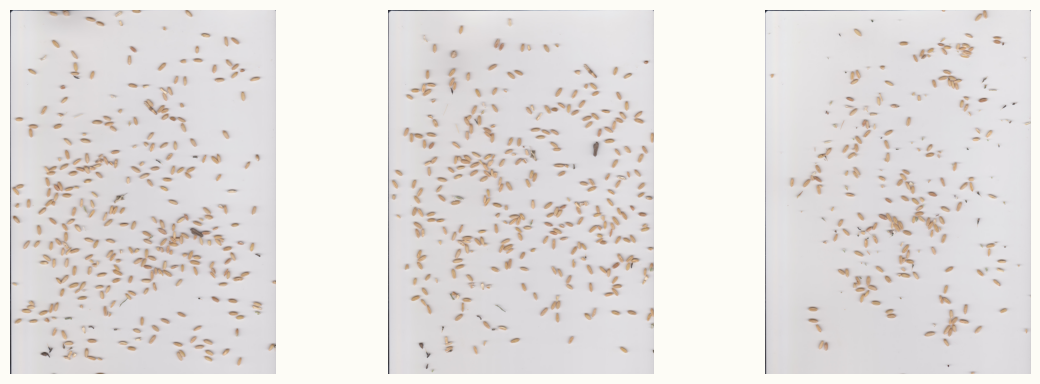

In [4]:
plotImages(scannedImages[0:3])

# 1. Extracting seeds and miscs with shadow
**Insights**:
- We extract objects with shadows because we require them to simulate real scanner images for our synthetic data.
- Later we will need also a filter removing this shadows.

In [10]:
# extraction
write=True
for image in scannedImages:
    grayImage = 255 - cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, thresholdImage = cv.threshold(grayImage, 50, 255, cv.THRESH_BINARY)

    copyImage = image.copy()
    contours, _ = cv.findContours(thresholdImage, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(copyImage, contours, -1, (255), thickness=cv.FILLED)

    if write: 
        for i, contour in enumerate(contours):
            x, y, w, h = cv.boundingRect(contour)
            if w*h <10:
                continue
            roi = image[y:y+h, x:x+w]
            transparentImg = np.zeros((h, w, 4), dtype=np.uint8)
            mask = np.zeros((h, w), dtype=np.uint8)
            cv.drawContours(mask, [contour - (x, y)], 0, (255), -1)
            transparentImg[:, :, :3] = roi
            transparentImg[:, :, 3] = mask
            cv.imwrite(f"data/objects/wheat/contour_{i}.png", transparentImg)
    else:
        plotImages([image ,copyImage])
        clear_output(wait=True)
        cv.waitKey(5000)

# 2. Classifing seeds and miscs in directories
### there is also pre-classified data as "seeds.zip" and "miscs.zip" so you can skip this step
**Insights**:
- I have Provided you a simple tool for classifying this images but a recommend you to do it by hand go to directory and drag and drop images(change folder view items to large icons) in two directories, i took me 5 minutes to classify this data.

data/objects/wheat/contour_10.png
(89, 72, 3)


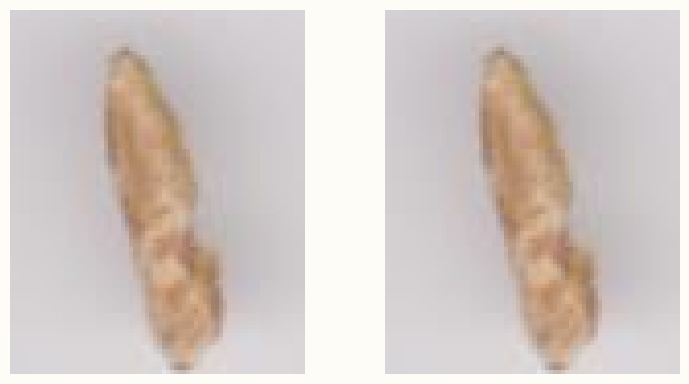

In [11]:
# classification
imageFileNames = sorted(os.listdir('data/objects/wheat'))
for name in imageFileNames:
    print(f'data/objects/wheat/{name}')
    currentImage = cv.imread(f'data/objects/wheat/{name}')
    print(currentImage.shape)
    plotImages([currentImage, currentImage])
    clear_output(wait=True)
    key = input("Press 'a' to save to directory_a, 'b' to save to directory_b, or 'n' for next image and 'e' to exit: ")
    
    if key == 's':
        cv.imwrite(os.path.join('data/objects/wheat/seeds', name), currentImage)
    elif key == 'w':
        cv.imwrite(os.path.join('data/objects/wheat/miscs', name), currentImage)
    elif key == 'e':
        break
    else:
        continue

In [12]:
zipDirectory('data/objects/wheat/seeds', 'data/objects/wheat/seeds.zip')
zipDirectory('data/objects/wheat/miscs', 'data/objects/wheat/miscs.zip')

# 3. Generate Synetic data of scanned images
### We generate 60,000 pieces of data from the extracted objects with shadows
**Insights**:
- Alongside, we create a mask to serve as y_train..
- I created a "dataAugmentationLib.py" that imported first for generating this synethic data
- The mask undergoes shadow removal around objects, as described in the "Shadow elimination" section of this paper: https://www.researchgate.net/publication/262561060_Toward_an_automatic_wheat_purity_measuring_device_A_machine_vision-based_neural_networks-assisted_imperialist_competitive_algorithm_approach
- In the mask, seeds are represented as 1 and miscellaneous items as 0.5.
- each synethic scanned image is splited to six equal images vertically(because of gpu memory limitations), so we generate 10000.

In [12]:
background_img = cv.imread("./data/blank.jpg") - 24
wheat_images, misc_images = [], []
loadImagesFromZip('data/objects/wheat/seeds.zip', wheat_images)
loadImagesFromZip('data/objects/wheat/miscs.zip', misc_images)

['contour_10.png', 'contour_1004.png', 'contour_1005.png', 'contour_1006.png', 'contour_1012.png', 'contour_1016.png', 'contour_1018.png', 'contour_102.png', 'contour_103.png', 'contour_1031.png', 'contour_104.png', 'contour_105.png', 'contour_106.png', 'contour_107.png', 'contour_109.png', 'contour_110.png', 'contour_111.png', 'contour_112.png', 'contour_114.png', 'contour_117.png', 'contour_120.png', 'contour_122.png', 'contour_123.png', 'contour_126.png', 'contour_131.png', 'contour_133.png', 'contour_135.png', 'contour_136.png', 'contour_138.png', 'contour_139.png', 'contour_149.png', 'contour_151.png', 'contour_152.png', 'contour_154.png', 'contour_158.png', 'contour_159.png', 'contour_160.png', 'contour_162.png', 'contour_164.png', 'contour_165.png', 'contour_168.png', 'contour_169.png', 'contour_170.png', 'contour_172.png', 'contour_175.png', 'contour_176.png', 'contour_177.png', 'contour_178.png', 'contour_18.png', 'contour_19.png', 'contour_191.png', 'contour_194.png', 'contou

### this may take long, took me 10 minutes

In [ ]:
IMAGE_SHAPE = (600, 816) 
IMAGE_SHAPE_OUT = (600, 136) 
visualization = True
for i in range(10000):
    augmentedImage, augmentedMask = placeImagesOnBackground(background_img, wheat_images, misc_images)
    cv.imwrite(f'./data/augmented/image/{i}.jpg', cv.resize(cv.cvtColor(augmentedImage, cv.COLOR_BGR2RGB), IMAGE_SHAPE))
    cv.imwrite(f'./data/augmented/mask/{i}.jpg', cv.resize(augmentedMask, IMAGE_SHAPE))
    if i%1000==0:
        print(i, " images saved")
    if visualization: 
        plotImages([cv.resize(cv.cvtColor(augmentedImage, cv.COLOR_BGR2RGB), IMAGE_SHAPE), cv.resize(augmentedMask, IMAGE_SHAPE)])
        clear_output(wait=True)
    # x_train.append(cv.resize(augmentedImage, IMAGE_SHAPE))
    # y_train.append(cv.resize(augmentedMask, IMAGE_SHAPE_OUT))

In [15]:
del wheat_images, misc_images, augmentedImage, augmentedMask

In [ ]:
zipDirectory('data/augmented/image', 'data/augmented/image.zip')
zipDirectory('data/augmented/mask', 'data/augmented/mask.zip')

# 4. Train Model
### The number and size of data must be customized based on your PC specifications.
**specs**:
- Nvidia GeForce GTX 1660 Ti
- Intel® Core™ i7-4790K
- 16 Gigabytes of DDR3 Memory

In [18]:
x_train, y_train = [], []
x_test, y_test = [], []

In [19]:
loadImagesFromZipSplited('./data/augmented/image.zip', x_train)
loadImagesFromZipSplited('./data/augmented/mask.zip', y_train)

['image/', 'image/0.jpg', 'image/1.jpg', 'image/10.jpg', 'image/100.jpg', 'image/1000.jpg', 'image/1001.jpg', 'image/1002.jpg', 'image/1003.jpg', 'image/1004.jpg', 'image/1005.jpg', 'image/1006.jpg', 'image/1007.jpg', 'image/1008.jpg', 'image/1009.jpg', 'image/101.jpg', 'image/1010.jpg', 'image/1011.jpg', 'image/1012.jpg', 'image/1013.jpg', 'image/1014.jpg', 'image/1015.jpg', 'image/1016.jpg', 'image/1017.jpg', 'image/1018.jpg', 'image/1019.jpg', 'image/102.jpg', 'image/1020.jpg', 'image/1021.jpg', 'image/1022.jpg', 'image/1023.jpg', 'image/1024.jpg', 'image/1025.jpg', 'image/1026.jpg', 'image/1027.jpg', 'image/1028.jpg', 'image/1029.jpg', 'image/103.jpg', 'image/1030.jpg', 'image/1031.jpg', 'image/1032.jpg', 'image/1033.jpg', 'image/1034.jpg', 'image/1035.jpg', 'image/1036.jpg', 'image/1037.jpg', 'image/1038.jpg', 'image/1039.jpg', 'image/104.jpg', 'image/1040.jpg', 'image/1041.jpg', 'image/1042.jpg', 'image/1043.jpg', 'image/1044.jpg', 'image/1045.jpg', 'image/1046.jpg', 'image/1047.

In [20]:
def data_generator(datax, datay, batch_size=1000):
    num_samples = len(datax)
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    while True:
        # np.random.shuffle(datax)
        # np.random.shuffle(datay)
        # Generate and yield batches
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_data_x = np.array(datax[start_idx:end_idx], dtype=np.float32)/255
            batch_data_y = np.array(datay[start_idx:end_idx], dtype=np.float32)/255

            # batch_data_x = tf.convert_to_tensor(datax[start_idx:end_idx], np.float32)
            # batch_data_y = tf.convert_to_tensor(datax[start_idx:end_idx], np.float32)
            yield batch_data_x, batch_data_y

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [22]:
train_gen = data_generator(x_train, y_train, batch_size=100)
test_gen = data_generator(x_test, y_test, batch_size=100)

In [23]:
conv_encoder = keras.models.Sequential([  # Convolutional Auto Encoder
    keras.layers.Reshape([IMAGE_SHAPE_OUT[1], IMAGE_SHAPE_OUT[0], 3], input_shape=[IMAGE_SHAPE_OUT[1], IMAGE_SHAPE_OUT[0], 3]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    # keras.layers.Dropout(0.2),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    # keras.layers.Dropout(0.2),
    keras.layers.Conv2D(8, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2D(8, kernel_size=3, padding="same", activation="relu"),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [24]:
conv_ae.compile(loss="mse", optimizer=keras.optimizers.Adam(), )#learning_rate=0.001

In [25]:
conv_ae.fit_generator(train_gen, steps_per_epoch=len(x_train)//100, epochs=200, validation_data=test_gen, validation_steps=len(x_test)//100)

Epoch 1/100
23/23 [==============================] - 16s 317ms/step - loss: 0.1321 - val_loss: 0.0958
Epoch 2/100
23/23 [==============================] - 9s 301ms/step - loss: 0.0961 - val_loss: 0.0958
Epoch 3/100
23/23 [==============================] - 7s 307ms/step - loss: 0.0961 - val_loss: 0.0958
Epoch 4/100
23/23 [==============================] - 7s 327ms/step - loss: 0.0961 - val_loss: 0.0958
Epoch 5/100
23/23 [==============================] - 7s 308ms/step - loss: 0.0962 - val_loss: 0.0958
Epoch 6/100
23/23 [==============================] - 8s 357ms/step - loss: 0.0963 - val_loss: 0.0958
Epoch 7/100
23/23 [==============================] - 8s 360ms/step - loss: 0.0962 - val_loss: 0.0956
Epoch 8/100
23/23 [==============================] - 8s 357ms/step - loss: 0.0901 - val_loss: 0.0858
Epoch 9/100
23/23 [==============================] - 8s 364ms/step - loss: 0.0853 - val_loss: 0.0845
Epoch 10/100
23/23 [==============================] - 8s 371ms/step - loss: 0.0844 - val_l

### You can also load my model if you cant do training

In [33]:
conv_ae = load_model('model copy 2.h5')

# 4. Test Final Model

### Test on synethic data

1/1 [==============================] - 0s 18ms/step


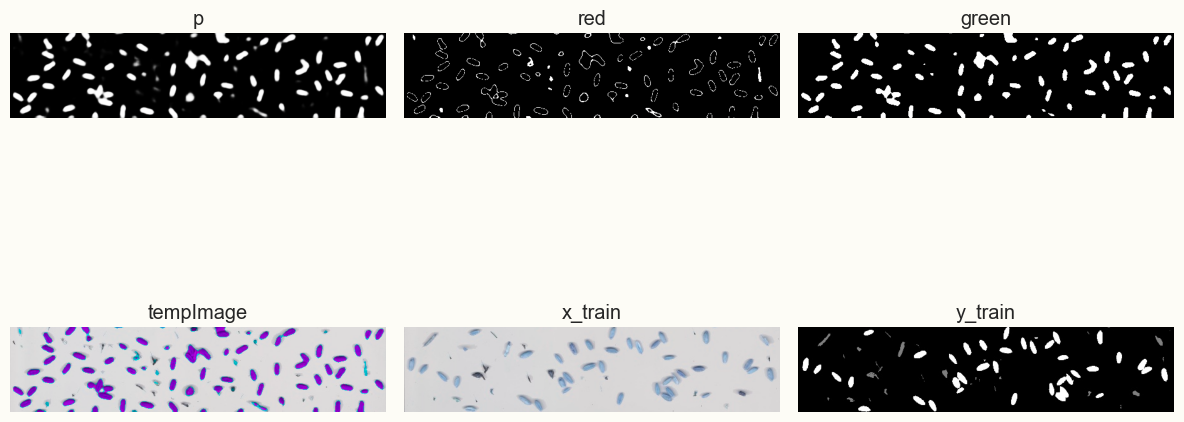

In [28]:
for i in range(10000):
    p = conv_ae.predict(np.array([x_test[i]/255], dtype=np.float32))
    red = p[0].copy()
    red[red>=0.75] = 0
    red[red<=0.25] = 0
    red[np.logical_and(red > 0.25, red < 0.75)] = 1
    red = np.reshape(red, (136, 600))

    green = p[0].copy()
    green[green>=0.75] = 1
    green[green<=0.25] = 0
    green[np.logical_and(green > 0.25, green < 0.75)] = 0
    green = np.reshape(green, (136, 600))

    tempImage = cv.resize(x_test[i], (600, 136))
    tempImage[:, :, 1] = np.where(green == 1, 1, tempImage[:, :, 1])
    tempImage[:, :, 2] = np.where(red == 1, 1, tempImage[:, :, 2])

    plotImages([p[0], red, green, tempImage,x_train[i], y_train[i]], ['p', 'red', 'green', 'tempImage', 'x_train', 'y_train'])
    clear_output(wait=True)
    n = input("next?")
    if n=='e':
        break
cv.destroyAllWindows()

### Test on Real Scanned data + Purity measurement
#### Purity measurement is calculated with Wheat mass percentage green/(red+green)

purity number(درصد خلوص):  0.7981617292953754


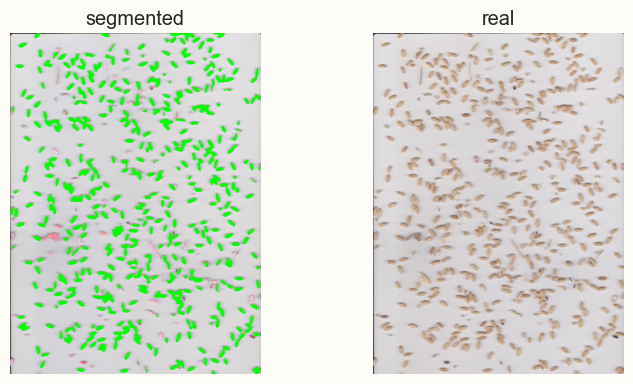

In [35]:
image = cv.imread('./data/3_2.jpg')
image = image.astype('float32')/255
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = np.array([cv.resize(image, (600, 816))])

image1 = image.copy()
image2 = image1.copy()
print(image2.shape)
image2 = cv.cvtColor(image2[0], cv.COLOR_RGB2BGR)

images = np.split(image[0], 6)
results = conv_ae.predict(np.array(images))

redCount = 0
greencount = 0
for i in range(len(results)):
    red = results[i].copy()
    red[red>=0.75] = 0
    red[red<=0.25] = 0
    red[np.logical_and(red > 0.25, red < 0.75)] = 1
    red = np.reshape(red, (136, 600))
    redCount+=np.count_nonzero(red == 1)

    green = results[i].copy()
    green[green>=0.75] = 1
    green[green<=0.25] = 0
    green[np.logical_and(green > 0.25, green < 0.75)] = 0
    green = np.reshape(green, (136, 600))
    greencount+=np.count_nonzero(green == 1)

    tempImage = images[i].copy()
    tempImage[:, :, 2] = np.where(red == 1, 1, tempImage[:, :, 2])
    # tempImage[:, :, 0] = np.where(red == 1, 0, tempImage[:, :, 0])
    # tempImage[:, :, 1] = np.where(red == 1, 0, tempImage[:, :, 1])

    
    tempImage[:, :, 1] = np.where(green == 1, 1, tempImage[:, :, 1])
    tempImage[:, :, 0] = np.where(green == 1, 0, tempImage[:, :, 0])
    tempImage[:, :, 2] = np.where(green == 1, 0, tempImage[:, :, 2])


    image1[0, i*136:(i+1)*136] = tempImage

    print("purity number(درصد خلوص): ", greencount/(redCount+greencount))
    plotImages([image1[0], image2], ['segmented', 'real'])
    clear_output(wait=True)

cv.destroyAllWindows()